**student:** Ewa Pelc

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [2]:
spark = SparkSession.builder.config("spark.sql.streaming.schemaInference", True).getOrCreate()

stream = spark.\
    readStream.\
    format("ws").\
    option("schema", "ticker").\
    load() # we need to pass `option("schema", "ticker")` to get correct channel subscribed

query = stream.select("side", "product_id", "last_size", "best_bid", "best_ask", "time").\
    writeStream.\
    format("console").\
    outputMode("append").\
    option("truncate", "false").\
    start()

query.awaitTermination(10) # Let's wait for 10 seconds.
query.stop() # Let's stop the query
stream.printSchema()
#spark.stop() # And stop the whole session

root
 |-- type: string (nullable = false)
 |-- trade_id: long (nullable = false)
 |-- sequence: long (nullable = false)
 |-- time: timestamp (nullable = false)
 |-- product_id: string (nullable = false)
 |-- price: double (nullable = false)
 |-- side: string (nullable = false)
 |-- last_size: double (nullable = false)
 |-- best_bid: double (nullable = false)
 |-- best_ask: double (nullable = false)



Uruchamiająć `stream.start()` uruchamiamy w osobnym demonie websocket który streamuje wyniki. Jeżeli wystąpi jakiś błąd po stronie front-endu (np. błąd parsowania kolejnej linijki Pythona) fakt ten nie zostanie zgłoszony do sparka i socket pozostanie otwarty! Należy pamiętać, by zamykać stream za każdym razem używająć metody `stop()` (w powyższym przykładzie `query.stop()`). W przypadku utracenia referencji do zapytania, należy zastopować całą sesję również metodą `stop()` (w powyższym przykładzie `spark.stop()`) 

In [3]:
# Panic button - press only if you messed up opening new websocket and lost reference to it

query.stop()
spark.stop()

# Zadanie 1

**Analiza strumienia danych CoinBase (3p)**. Napisz zapytanie, które wypisuje średnią wartość wybranego parametru (np. `price`) w przesuwnych oknach czasowych względem czasu transakcji (kolumna `time`), grupując po relacji wymiany (z jakiej waluty na jaką walutę - kolumna `product_id`). 

In [4]:
from pyspark.sql.functions import window, avg

In [5]:
average_price_df = stream \
    .groupBy(
        window("time", "15 seconds", "5 seconds"),  # Przesuwne okno czasowe
        "product_id"  # Grupowanie po relacji wymiany
    ) \
    .agg(avg("price").alias("average_price"))  # Obliczenie średniej ceny



query = average_price_df.\
    writeStream \
    .format("memory") \
    .queryName("average_price_table") \
    .outputMode("complete") \
    .start()

query.awaitTermination(60) # Let's wait for 10 seconds.
query.stop() # Let's stop the query

In [6]:
import pandas as pd

result = spark.sql("SELECT * FROM average_price_table order by window, product_id")
pandas_df = result.toPandas()  

display(pandas_df)

,window,product_id,average_price
0,"(2024-11-13 13:01:40, 2024-11-13 13:01:55)",ETH-BTC,0.036090
1,"(2024-11-13 13:01:45, 2024-11-13 13:02:00)",ETH-BTC,0.036090
2,"(2024-11-13 13:01:50, 2024-11-13 13:02:05)",ETH-BTC,0.036090
3,"(2024-11-13 13:02:00, 2024-11-13 13:02:15)",BTC-EUR,82576.640000
4,"(2024-11-13 13:02:05, 2024-11-13 13:02:20)",BTC-EUR,82599.270000
5,"(2024-11-13 13:02:05, 2024-11-13 13:02:20)",BTC-USD,87896.573750
6,"(2024-11-13 13:02:05, 2024-11-13 13:02:20)",ETH-USD,3170.748000
7,"(2024-11-13 13:02:10, 2024-11-13 13:02:25)",BTC-EUR,82605.725000
8,"(2024-11-13 13:02:10, 2024-11-13 13:02:25)",BTC-USD,87889.858056
9,"(2024-11-13 13:02:10, 2024-11-13 13:02:25)",ETH-USD,3170.485455


In [7]:
query = average_price_df.writeStream \
    .format("console") \
    .outputMode("complete") \
    .option("truncate", "false") \
    .start()

query.awaitTermination(60)  # Czeka na wyniki przez 60 sekund
query.stop()  # Zatrzymuje zapytanie

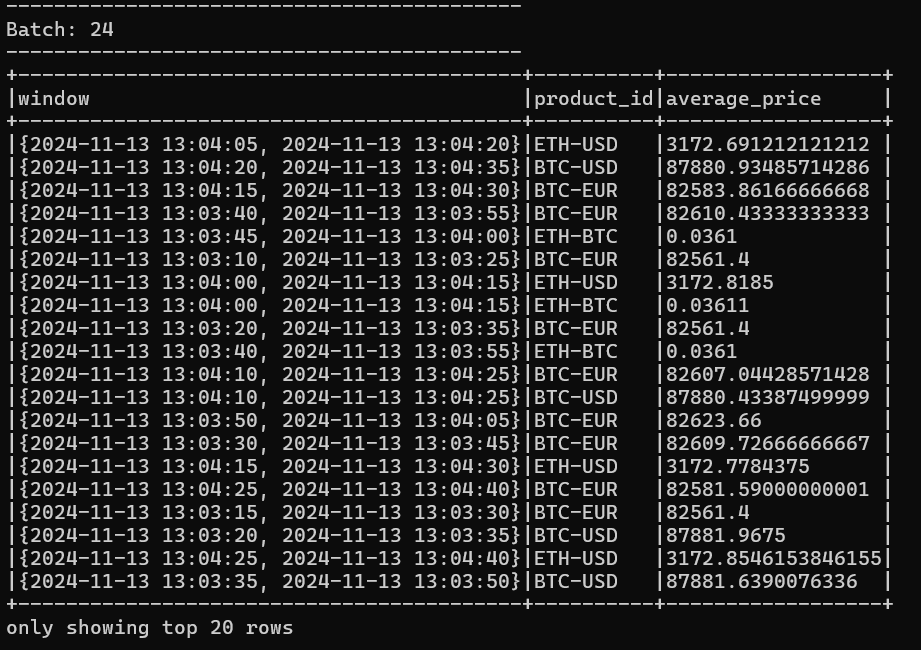

In [8]:
from IPython.display import display, Image


display(Image(filename="zadanie1.png"))

# Zadanie 2

**Watermarking i dane opóźnione (3p).** 
Zmodyfikuj zapytanie z zadania 1 tak, aby zademonstować mechanizm znaków wodnych (watermarks) i obsługi danych opóźnionych. W konsoli powinno być widać, że aktualizują się odpowiednie wiersze tabeli wynikowej (tryb update), w szczególności aktualizacja wcześniejszych okien czasowych po przybyciu danych opóźnionych. **Do rozwiązania tego zadania proszę dołączyć przykładowy output i jego opis wyjaśniający na konkretnym przykładzie działanie znaku wodnego i danych opóźnionych**. 

Do ćwiczenia można wykorzystać skrypt w katalogu `/mock` napisany w [Scala-cli](https://scala-cli.virtuslab.org), który posłuży jako kontrolowane źródło danych CoinBase przez Websocket. 

Skrypt można uruchomić wykorzystując Docker:

```
make image
make run
```

Spowoduje to utworzenie websocketowego serwera pod adresem `ws://mock:8025`

Po uruchomieniu serwera należy wykonać poniższą komórkę, w której zapytanie czyta dane z utworzonego websocketa. Skrypt wysyła przykładowe wiadomości w formacie CoinBase co 10 sekund:

- W pierwszej serii wysyłane wiadomości o znacznikach czasowych 0s, 14s, 7s  
- W drugiej serii wysyłane są wiadomości o znacznikach czasowych 15s, 8s, 21s  
- W trzeciej serii wysyłane są wiadomości o znacznikach czasowych 4s, 17s  

Dla tych danych można ustawić okno czasowe na interwał 10 sekund. Skrypt można też zmodyfikować, tak aby wysyłał inne dane. 


In [14]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config("spark.sql.streaming.schemaInference", True).config("spark.sql.streaming.forceDeleteTempCheckpointLocation", True).getOrCreate()  
stream = spark.readStream.format("ws").option("schema", "ticker").load()


average_price_df = stream \
    .withWatermark("time", "15 seconds")  \
    .groupBy(
        window("time", "15 seconds", "5 seconds"),  
        "product_id"  
    ) \
    .agg(avg("price").alias("average_price"))  


# update - aby obserwować zmiany w oknach
query = average_price_df.writeStream \
    .format("console") \
    .outputMode("update") \
    .option("truncate", "false") \
    .start()

query.awaitTermination(60)  
query.stop() 


**Komentarz:**

Watermark 15 sekund, oznacza że Spark będzie akceptował dane opóźnione o 15 sekund. 
Czyli spark aktualizuje starsze okna danymi które napłynęły później.


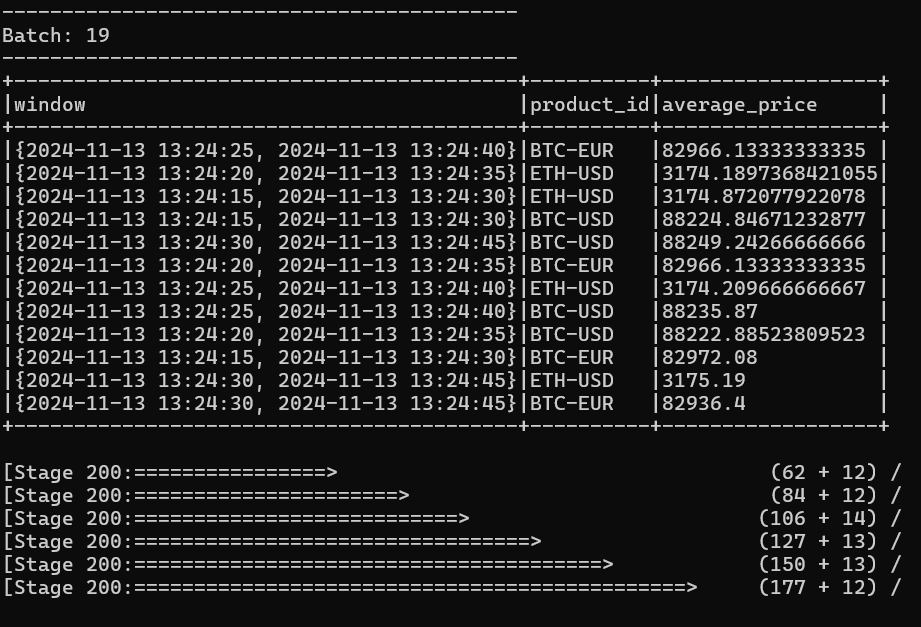

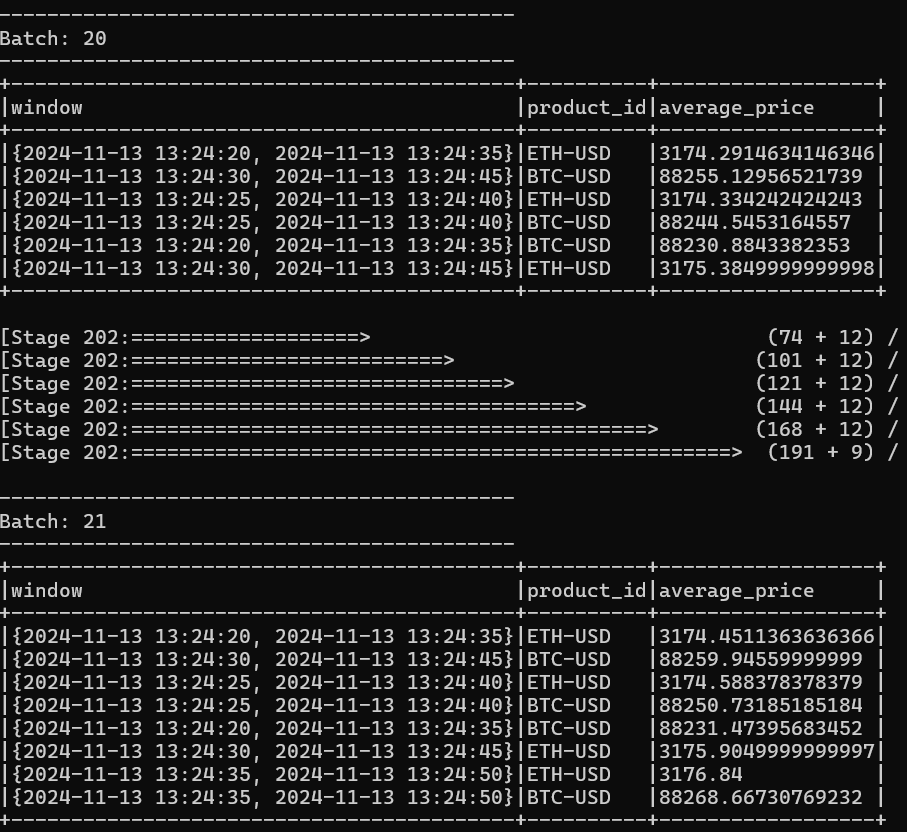

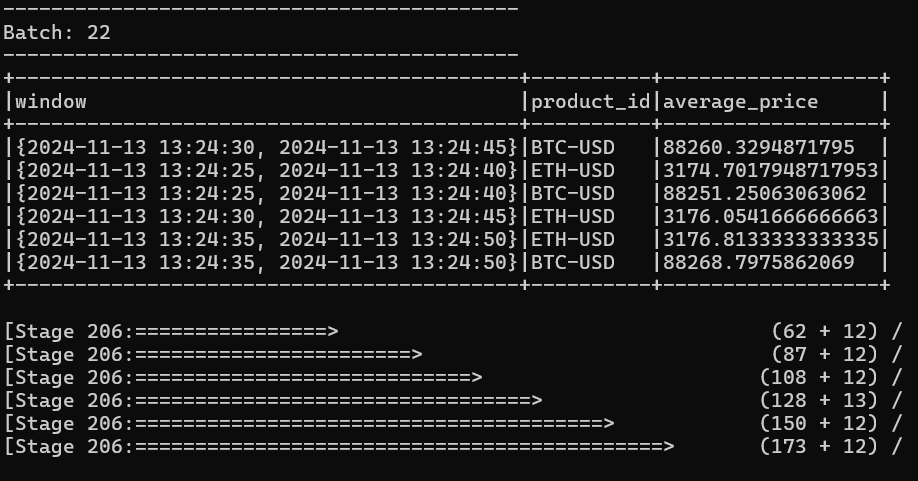

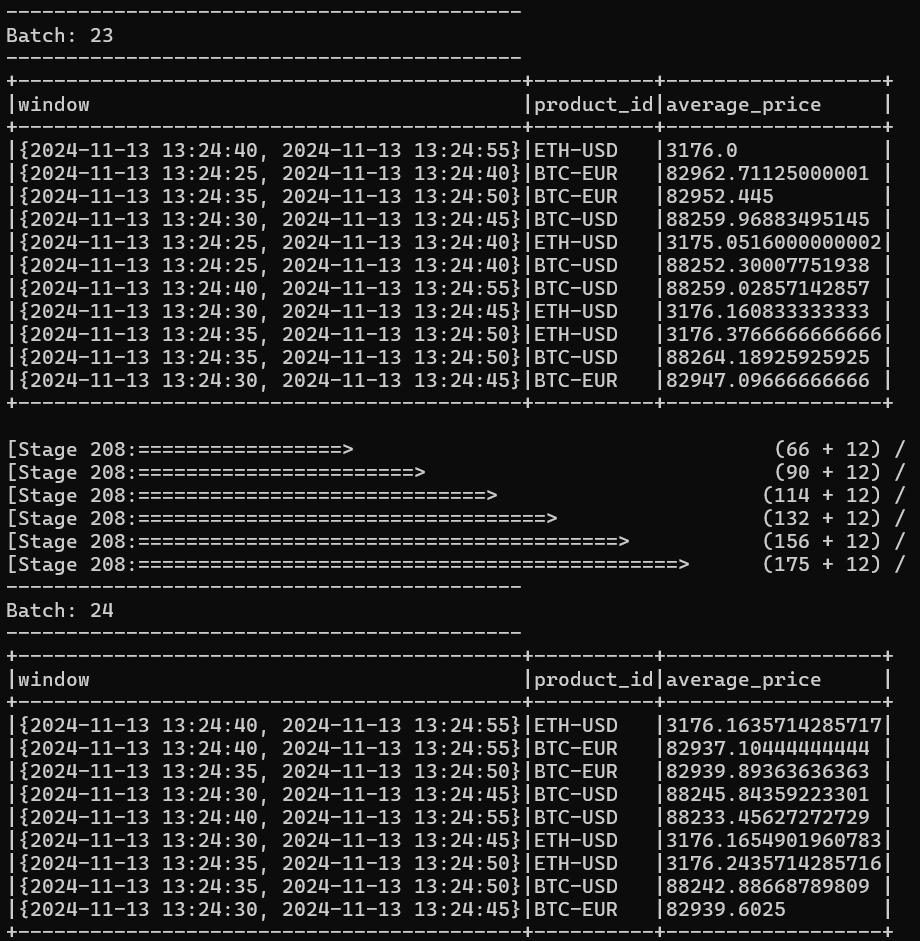

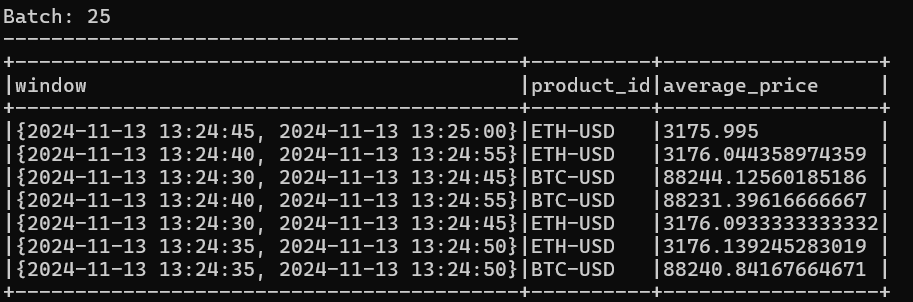

In [16]:
from IPython.display import display, Image


display(Image(filename="zadanie2_batch19.png"))
display(Image(filename="zadanie2_batch20-21.png"))
display(Image(filename="zadanie2_batch22.png"))
display(Image(filename="zadanie2_batch23-24.png"))
display(Image(filename="zadanie2_batch25.png"))

**Wybrane wyniki (okno: {13:24:30 - 13:24:45}/ product_id: BTC-USD)**


batch 19:

|{2024-11-13 13:24:30, 2024-11-13 13:24:45}|BTC-USD   |**88249.24266666666** |

batch 20:
|{2024-11-13 13:24:30, 2024-11-13 13:24:45}|BTC-USD   |**88255.12956521739** |

batch 21:

|{2024-11-13 13:24:30, 2024-11-13 13:24:45}|BTC-USD   |**88259.94559999999** |

batch 22:

|{2024-11-13 13:24:30, 2024-11-13 13:24:45}|BTC-USD   |**88260.3294871795**  |

batch 23:

|{2024-11-13 13:24:30, 2024-11-13 13:24:45}|BTC-USD   |**88259.96883495145** |

batch 24:

|{2024-11-13 13:24:30, 2024-11-13 13:24:45}|BTC-USD   |**88245.84359223301** |

batch 25:

|{2024-11-13 13:24:30, 2024-11-13 13:24:45}|BTC-USD   |**88244.12560185186** |

**Komentarz:**

Okno czasowe {13:24:30, 13:24:45} po raz pierwszy pojawia się w batchu 19, widzimy kolejne zmiany zagregowanych wartości. Okno ma szerokość 15 sekund, co 5 sekund tworzone są nowe okna, oraz opóźnienie to 15 sekund. Gdyby nie było opóżnienia, to mielibyśmy ostalony wynik po kilku pierwszych iteracjach, ale spark czeka jeszcze 15 sekund żeby ustalić końocwy wynik.

Ostateczna wartość dla tego okna ustali się dopiero wtedy, gdy minie okres watermark (czyli 15 sekund po 13:24:45, to będzie 13:25:00), i nie pojawią się nowe dane w ramach tego opóźnienia.

Widzimy, że w batchu 25 pojawia się po raz pierwszy okno czasowe {13:24:45, 13:25:00}, tzn że wartość dla okna {13:24:30, 13:24:45} jest ostateczna.
||


# Zadanie 3

**Łączenie strumieni (3p)**. Korzystając z łączenia strumieni połącz dane z kanału `ticker` (transakcje kupna `side="buy"`) razem z danymi o transakcjach napływających co sekundę `heartbeat` korzystając z `trade_id` i odpowiedniego id w kanale heartbeat. Wypisz połączony strumień danych.

Na moment tworzenia zadania 15.11.2023 kanał `heartbeat` zwraca błędne dane o dacie (np. `1970-01-04 13:53:57.645339`). Połączenie z kanałem `ticker` pozwala uzyskać poprawne informacje. Cóż za wspaniałe zastosowanie joina!


In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.\
    builder.\
    config("spark.sql.streaming.schemaInference", True).\
    config("spark.sql.streaming.forceDeleteTempCheckpointLocation", True).\
    getOrCreate()  

ticker_stream = spark.\
    readStream.\
    format("ws").\
    option("schema", "ticker").\
    load()

heartbeat_stream = spark.readStream \
    .format("ws") \
    .option("schema", "heartbeat") \
    .load()


In [22]:
# tylko transakcje kupna z ticker
buy_transactions = ticker_stream.filter(col("side") == "buy")

# join strumieni
joined_stream = heartbeat_stream.join(
    buy_transactions,
    heartbeat_stream["last_trade_id"] == buy_transactions["trade_id"],
    "inner"
).select(
    heartbeat_stream["last_trade_id"].alias('trade_id'),
    buy_transactions["product_id"],
    buy_transactions["price"],
    buy_transactions["time"].alias("corrected_time")
)


query = joined_stream.writeStream \
    .format("console") \
    .outputMode("append") \
    .option("truncate", "false") \
    .start()

query.awaitTermination(60)
query.stop()

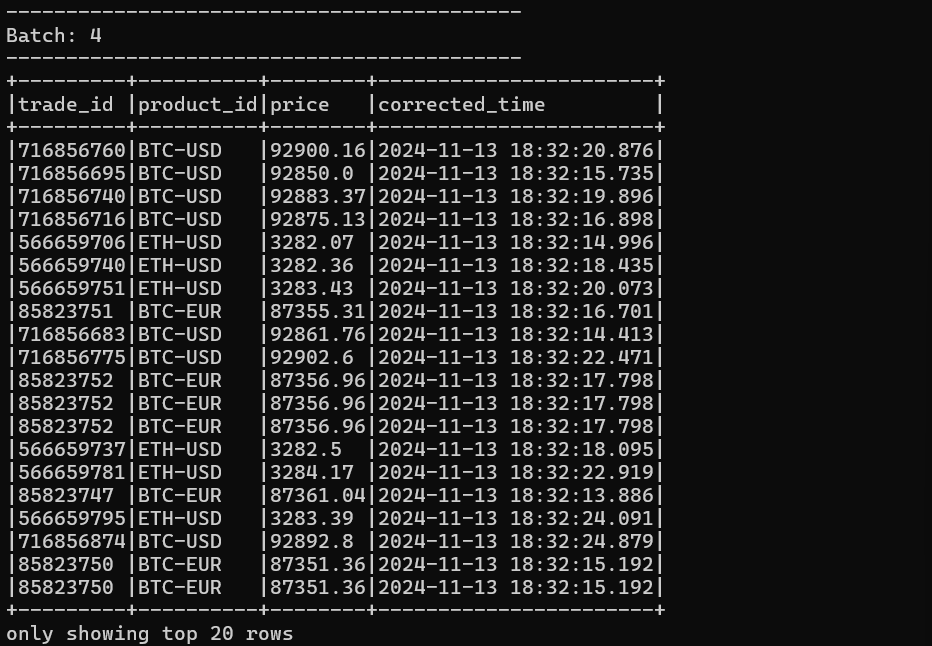

In [20]:
display(Image(filename="zadanie3.png"))